## Initialize Environment


In [1]:
!python -m venv venv

Error: [Errno 13] Permission denied: 'c:\\Users\\Magnico\\Documents\\GitProjects\\driver_detection\\venv\\Scripts\\python.exe'


Remember to change the kernel to the venv


In [2]:
%pip install opencv-python numpy Pillow ultralytics

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Magnico\Documents\GitProjects\driver_detection\venv\Scripts\python.exe -m pip install --upgrade pip' command.


## Import Dependencies


In [3]:
import cv2
import os
from datetime import datetime
from ultralytics import YOLO
import pandas as pd
from PIL import Image

In [4]:
SIZE = (WIDTH, HEIGHT) = (640, 480)

CLS_MODEL = r'models\1014\weights\last.pt'
CLASS_NAMES = {
    0: 'good',
    1: 'texting',
    2: 'talking',
    3: 'radio',
    4: 'drink',
    5: 'behind',
    6: 'passenger',
    7: 'Unknown'
}

SEG_MODEL = 'yolov8s-seg.pt'
SEG_KWARG = {
    'classes':  0,
    'imgsz': WIDTH,
    'boxes': True,
    'save': False,
    'show_labels': False,
    'show_conf': False,
    'max_det': 1,
    'verbose': False
}

SAVE_DIR = r'./captures'

THRESHOLD = 0.5

## Define Functions


In [5]:
def init_models(cls=CLS_MODEL, seg=SEG_MODEL):
    global img_seg_model, img_class_model
    img_seg_model = YOLO(seg)
    img_class_model = YOLO(cls)

def init_dataframe():
    global SAVE_DIR, df
    
    if not os.path.exists(SAVE_DIR):
        os.makedirs(SAVE_DIR)

    try:
        df = pd.read_csv('data.csv')
    except:
        df = pd.DataFrame(columns=['image_name', 'class', 'confidence', 'time'])
        df.to_csv('data.csv', index=False)

def init():
    init_models()
    init_dataframe()

In [6]:
def pre_process(image, size=SIZE):
    if image is None:
        print(f"Unable to read image")
        return None

    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # image = cv2.resize(image, size)

    return image

In [7]:
def apply_mask(image, _kwarg=SEG_KWARG):
    global img_seg_model

    # transform image from matlike to pil image
    image = Image.fromarray(image)

    image = img_seg_model(image, **_kwarg)

    return image[0].plot(conf=False, labels=False, pil=True)

In [8]:
def log_distraction(cls, conf, image):
    global SAVE_DIR, df

    now = datetime.now()
    image_name = f"{SAVE_DIR}/{cls}_{now.strftime('%Y%m%d%H%M%S')}.jpg"
    cv2.imwrite(image_name, image)


    df.loc[-1] = [image_name, cls, conf, now.strftime('%Y-%m-%d %H:%M:%S')]
    df.index = df.index + 1
    df = df.sort_index()
    


In [9]:
def predict_distraction(image):
    global CLASS_NAMES, THRESHOLD, img_class_model

    img = pre_process(image)

    img = apply_mask(img)

    probs = img_class_model(img, verbose=False)[0].probs
    cls = probs.top1
    conf = probs.top1conf.item()
    
    cls = CLASS_NAMES[cls if conf >= THRESHOLD else 7]

    log_distraction(cls, conf, img)
    
    return img, cls

## MAIN


In [12]:
# Initialize the camera
cap = cv2.VideoCapture(0)

# Calculate fps to wait between model predictions
times_per_second = 3
fps = cap.get(cv2.CAP_PROP_FPS)
wait = fps//times_per_second

# Initialize
init()

# Start the loop
frames = 0
cls = 'None'
while True:

    # Read the frame
    ret, frame = cap.read()

    if not ret:
        print("No more frames")
        break

    frame = cv2.resize(frame, SIZE)

    # Predict the distraction
    if frames % wait == 0:
        frame, cls = predict_distraction(frame)

    # Put the class name on the frame and show it
    cv2.putText(frame, cls+ ' - ' + str(frames), (10, 50),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    cv2.imshow('frame', frame)

    framef = frame
    frames += 1

    # Press q to early stop
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

df.to_csv('data.csv', index=False)

No more frames


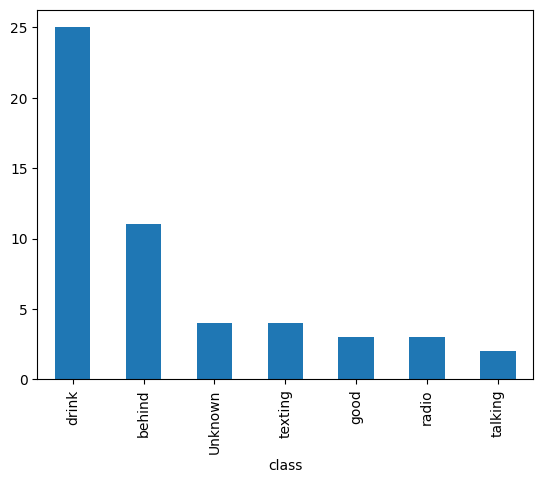

In [14]:
def plot_distractions():
    data = pd.read_csv('data.csv')

    data['class'].value_counts().plot(kind='bar')

plot_distractions()